# How to Use This Library

## Importing necessary libraries

In [1]:
import sys
import os

sys.path.append('..')

## Getting the data for this example

This example uses the IIT Bombay English-Hindi Parallel Corpus available [here](https://www.cfilt.iitb.ac.in/~parallelcorp/iitb_en_hi_parallel/). Steps to obtain the data (run the following cells):

1. Download the parallel corpus (`parallel.tgz`) and save it in the `raw` directory.
2. Switch to the `raw` directory using `cd raw` and run `tar -xvf parallel.tgz` to unzip.
3. Run `./crop.sh` to take a subset of the complete dataset.

When using your own data, make sure the bilingual corpus is split into two files, one for each language (similar to the example IIT Bombay dataset used here). The files must have the extension as the [ISO 639-1 code](https://en.wikipedia.org/wiki/List_of_ISO_639-1_codes) for the language. For example, the file containing English sentences could be named as `data.en` and the file containing the corresponding Hindi sentences as `data.hi`. Make sure that the document on line number $n$ in the target file (`data.hi`) is a translation of the corresponding document on line number $n$ in the source file (`data.en`).

In [2]:
raw_hi_path = os.path.join('raw', 'data.hi')
raw_en_path = os.path.join('raw', 'data.en')

preproc_dir = 'preprocessed'
preproc_hi_path = os.path.join(preproc_dir, 'data.hi')
preproc_en_path = os.path.join(preproc_dir, 'data.en')

Looking at the raw data.

In [3]:
import pandas as pd

pd.concat([pd.read_csv(raw_hi_path, sep='\t', nrows=10, header=None), pd.read_csv(raw_en_path, sep='\t', nrows=10, header=None)], axis=1)

,0,0
0,उन्होंने विश्वास व्यक्त किया कि न्यायपालिका सद...,He was confident that the judiciary will alway...
1,यह विज्ञप्ति 1220 बजे जारी की गई।,This release issued at 1220 hrs.
2,तिरुवनंतपुरम में राष्ट्रपति के सम्मान में नागर...,CIVIC RECEPTION HOSTED IN HONOUR OF THE PRESID...
3,राष्ट्रपति भवन : 27.10.2017,Rashtrapati Bhavan : 27.10.2017
4,"भारत के राष्ट्रपति, श्री राम नाथ कोविन्द ने आज...","The President of India, Shri Ram Nath Kovind, ..."
5,"इस अवसर पर, राष्ट्रपति ने कहा कि केरल ऐतिहासिक...","Speaking on the occasion, the President said t..."
6,"इस अवसर पर, राष्ट्रपति ने कहा कि केरल की परम्प...",The President said that Kerala’s traditions an...
7,केरल में मानव विकास और स्वास्थ्य देखभाल तथा शि...,The emphasis on human development and on healt...
8,स्वच्छता में केरल की उपलब्धियां सराहनीय हैं।,"In sanitation, Kerala’s achievements are prais..."
9,स्थानीय स्वशासन और पंचायती राज में एक बार फिर ...,"In local self-government and panchayati raj, a..."


## Preprocessing

The `preprocess` module has two builtin preprocessing functions, one for normalizing the textual data and another for tokenizing it.

In [4]:
from indic_aug.preprocess import Preprocess

In [5]:
%%bash

rm -rf preprocessed
mkdir preprocessed

In [6]:
preproc = Preprocess(
    raw_hi_path,
    raw_en_path
)
preproc.preprocess(
    preproc_hi_path,
    preproc_en_path,
    512,                                         # Number of parallel documents to bring into memory at a time.
    funcs=['normalize', 'pretokenize']          # Functions applied in order specified.
)

100%|██████████| 40/40 [00:25<00:00,  1.58it/s]


## Building the vocabulary

In [7]:
%%bash

rm -rf vocab
mkdir vocab

In [8]:
from indic_aug.vocab import build_vocab

In [9]:
build_vocab(
    preproc_hi_path,
    preproc_en_path,
    2000,           # Source (en) vocab size
    2000,           # Target (hi) vocab size
    'vocab'
)

## `SynonymAugmentor`

This section shows how to use the `SynonymAugmentor` from the `basic` package. Other augmentors from the `basic` package can be used similarly.

In [10]:
from indic_aug.basic import SynonymAugmentor

In [11]:
synonymAugmentor = SynonymAugmentor(
    preproc_hi_path,
    preproc_en_path,
    0.3
)

2021-05-02:04:18:51,970 INFO     [utils.py:157] NumExpr defaulting to 4 threads.


In [12]:
i = 0
for augmentedPair in synonymAugmentor:
    print(augmentedPair)
    if i == 10:
        break
    else:
        i += 1

('उन्होंने ऐतबार व्यक्त किया कि न्यायपालिका सदैव उन बडी उम्मीदों पर खरा उतरेगी जिसकी हमारी जनता अपेक्षा करती है', 'He was convinced that the judicial_system will always live up to the high arithmetic_mean that our people have of it')
('यह इश्तिहार 1220 बजे रूढ़ की गई', 'This release issued at 1220 hrs')
('तिरुवनंतपुरम में राष्ट्रपति के सम्मान में नागरिक अभिनंदन समारोह आयोजित किया गया', 'CIVIC RECEPTION HOSTED IN honour OF THE PRESIDENT IN THIRUVANANTHAPURAM')
('राष्ट्रपति भवन : 27 10 2017', 'Rashtrapati Bhavan : 27.10.2017')
('भारत के राष्ट्रपति , श्री राम नाथ कोविंद ने आज ( 27अक्तूबर , 2017 ) टैगोर थियेटर , तिरुवनंतपुरम् में अपने सम्मान में आयोजित एक देशवासी अभिनंदन समारोह को संबोधित किया', 'The chairwoman of Bharat , Shri Ram Nath Kovind , addressed a civic reception hosted for him at Tagore dramatic_art , Thiruvananthapuram today ( Oct 27 , 2017 )')
('इस अवसर पर , राष्ट्रपति ने कहा कि केरल ऐतिहासिक रूप से आदि शंकराचार्य से लेकर श्री नारायण गुरु और अय्यनकली तक और अन्य अनेक की आध्यात्

## `DepParseAugmentor`

This section shows how to use `DepParseTree` and `DepParseAugmentor` from the `depparse` package.

In [13]:
import stanza
import graphviz

from indic_aug.depparse import DepParseTree, DepParseAugmentor

Creating the sentence in the desired form as expected by `DepParseTree`.

In [14]:
nlp = stanza.Pipeline(verbose=False)
sent = nlp('Jack hit the ball with the bat').sentences[0]

Creating the dependency parse tree and saving it as a GraphViz DOT file.

In [15]:
deptree = DepParseTree(sent)
deptree.save_tree('deptree.dot')

Plotting the graph.

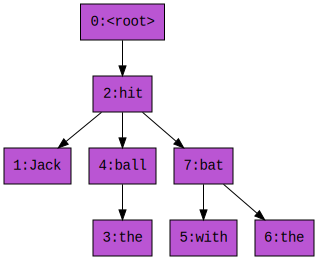

In [16]:
graphviz.Source.from_file('deptree.dot')

In [17]:
depparseAugmentor = DepParseAugmentor(
    os.path.join('preprocessed', 'data.hi'),
    os.path.join('preprocessed', 'data.en'),
    'dropout',
    0.2
)

In [18]:
i = 0
for augmentedPair in depparseAugmentor:
    print(augmentedPair)
    if i == 10:
        break
    else:
        i += 1

('उन्होंने विश्वास व्यक्त किया कि न्यायपालिका सदैव उन बडी उम्मीदों पर खरा उतरेगी हमारी जनता अपेक्षा करती है ।', 'He confident that will always live to the expectations that our people of it')
('यह विज्ञप्ति बजे जारी गई ।', 'This release issued at 1220 hrs .')
('तिरुवनंतपुरम में राष्ट्रपति के सम्मान में नागरिक अभिनंदन समारोह आयोजित किया गया', 'RECEPTION IN HONOUR THE PRESIDENT THIRUVANANTHAPURAM')
('राष्ट्रपति भवन 27 । 10 । ', 'Rashtrapati : 27.10.2017')
('भारत राष्ट्रपति , श्री राम कोविंद ने आज ( 27अक्तूबर 2017 टैगोर थियेटर तिरुवनंतपुरम अपने सम्मान आयोजित एक नागरिक अभिनंदन को संबोधित किया ।', 'The President India , Ram Nath Kovind addressed a civic reception for at Tagore Theatre , Thiruvananthapuram today ( October 27 , 2017 )')
('इस अवसर पर , राष्ट्रपति ने केरल ऐतिहासिक रूप आदि शंकराचार्य से लेकर श्री नारायण गुरु अय्यनकली तक और अन्य अनेक की आध्यात्मिक अगुवाई और सामाजिक सुधारों की परंपरा आध्यात्मिकता की भूमि ।', 'Speaking on the the President said Kerala a land of spiritualism , tradi

## `Aligner`

This section shows how to train an alignment model using `Aligner` from the `align` module.

In [19]:
from indic_aug.align import Aligner

In [20]:
%%script echo "Comment the line with \"%%script echo\" to run training again (this might take some time)."
%%time

aligner = Aligner('ibm1', 10)
aligner.train(preproc_hi_path, preproc_en_path)
aligner.serialize('aligner.pkl')

Comment the line with "%%script echo" to run training again (this might take some time).


In [21]:
aligner = Aligner.load('aligner.pkl')

In [22]:
for word in [
    'space',
    'economy',
    'science',
    'ordinary',
    'resolve',
    'standards',
    'high',
    'broadcast',
    'number',
    'conclave',
    'colleges',
    'technology',
    'quality',
    'officer',
    'city'
]:
    print(f'{word} - {aligner.get_closest_aligned(word)}')

space - अंतरिक्ष
economy - अर्थव्यवस्था
science - विज्ञान
ordinary - साधारण
resolve - संकल्प
standards - मानकों
high - ऊंचा
broadcast - प्रसारण
number - संख्या
conclave - प्रबासी
colleges - महाविद्यालयों
technology - प्रौद्योगिकी
quality - गुणवत्ता
officer - आरआर
city - शहर


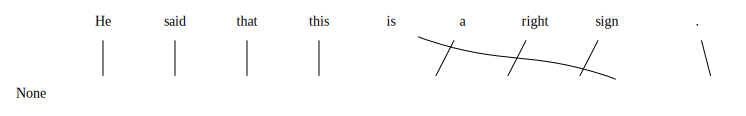

In [23]:
aligner.align('उन्होंने कहा कि यह एक सही संकेत है ।', 'He said that this is a right sign .')

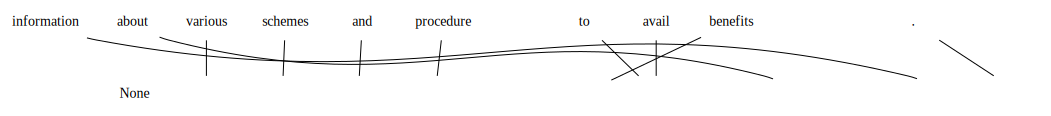

In [24]:
aligner.align('विभिन्न योजनाओं और प्रक्रियाओं का लाभ उठाने के बारे में जानकारी ।', 'information about various schemes and procedure to avail benefits .')

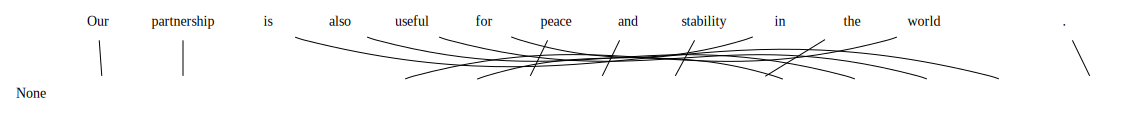

In [25]:
aligner.align('हमारी साझेदारी विश्व में शांति और स्थिरता के लिए भी उपयोगी है ।', 'Our partnership is also useful for peace and stability in the world .')

As can be seen above, it becomes difficult to visualize the alignments when the sentences become long. You can instead use the `plot_alignment` method in the `Align` object.

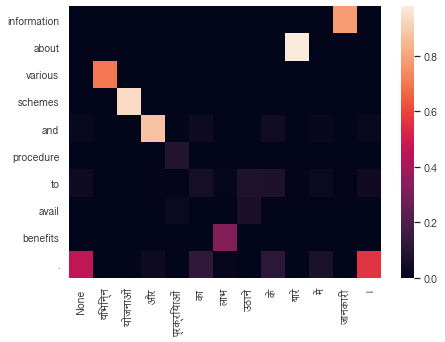

In [26]:
aligner.plot_alignment('विभिन्न योजनाओं और प्रक्रियाओं का लाभ उठाने के बारे में जानकारी ।', 'information about various schemes and procedure to avail benefits .', 'Devanagari Sangam MN', figsize=(7, 5))

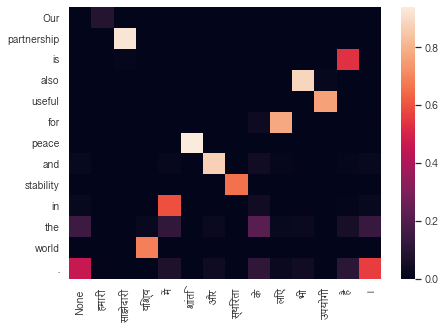

In [27]:
aligner.plot_alignment('हमारी साझेदारी विश्व में शांति और स्थिरता के लिए भी उपयोगी है ।', 'Our partnership is also useful for peace and stability in the world .', 'Devanagari Sangam MN', figsize=(7, 5))